### Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torch.utils.tensorboard import SummaryWriter
from scripts.data.dataset import DSLRDataset
from scripts.data.transforms import Resize, ToTensor, Normalize
from scripts.networks.nn_2d import MobileNetV3_Segmentation
from scripts.utils.load_save_models import save_checkpoint, get_latest_checkpoint, inference, load_checkpoint
from scripts.utils.visualizer import visualize_predictions, visualize_dataloader

# Set CUDA_LAUNCH_BLOCKING for accurate stack trace
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear GPU cache
torch.cuda.empty_cache()

# Set PYTORCH_CUDA_ALLOC_CONF to manage memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

/home/lukas/anaconda3/envs/3dmv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lukas/anaconda3/envs/3dmv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Prepare for Dataset

In [2]:
# Paths to dataset and split files
data_dir = 'dataset/data'
train_split_file = 'dataset/splits/nvs_sem_train.txt'
val_split_file = 'dataset/splits/nvs_sem_val.txt'

# Define the transforms
transform = T.Compose([
    Resize((146, 219)),  # Resize to fixed dimensions to 1/4 of original size
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Dataset

In [3]:
# Create datasets and dataloaders
train_dataset = DSLRDataset(data_dir, train_split_file, transform=transform)
val_dataset = DSLRDataset(data_dir, val_split_file, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)


### Visualize first

Visualizing data from the dataloader...
Loaded palette: [[0.40784314 0.8        1.        ]
 [0.7372549  0.74117647 0.13333333]
 [0.59607843 0.8745098  0.54117647]
 [1.         0.59607843 0.58823529]
 [0.83921569 0.15294118 0.15686275]]
Input image shape: (146, 219, 3), min: 0.0, max: 1.0
Label image shape: (146, 219), unique values: [-100  -75  -74  -72  -71  -68  -61  -50  -49  -48  -44  -36  -26  -25
  -24  -23  -22  -21  -19  -17  -16  -15  -12   -1    0    1    2    3
    4    5    6    7    8    9   10   11   12   13   14   15   16   17
   19   20   27   42   55]
Input image shape: (146, 219, 3), min: 0.0, max: 1.0
Label image shape: (146, 219), unique values: [-100  -75  -74  -73  -72  -71  -69  -50  -49  -48  -47  -46  -44  -42
  -38  -26  -25  -24  -23  -19  -18  -16  -13   -8   -1    0    1    2
    3    4    5    6    7    8    9   10   11   12   13   14   15   16
   17   18   20   21   23   24   27   28   30   36   39   42   46   50
   55   57   61   71   76   81]


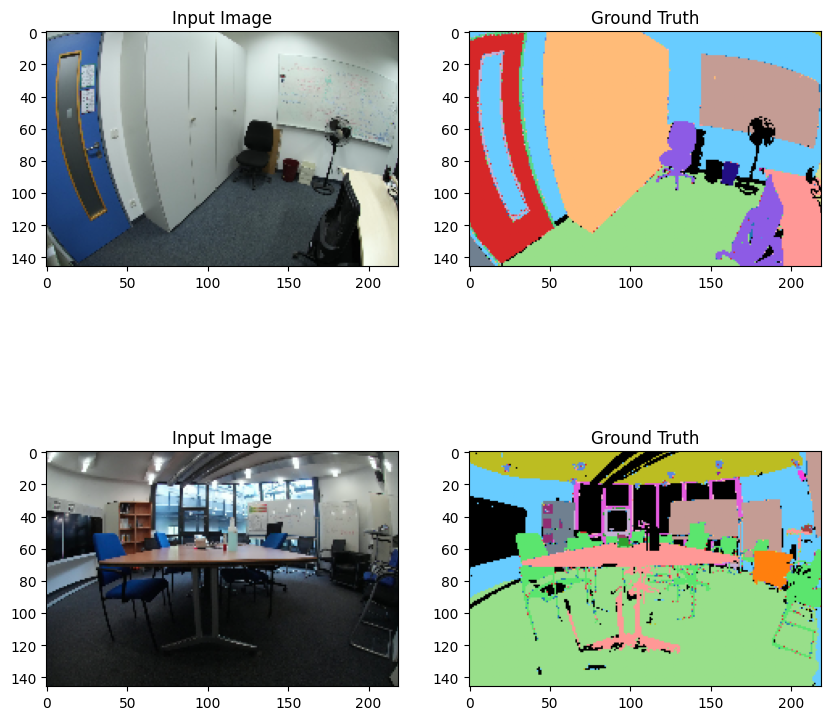

In [4]:
# Visualize data from the dataloader before training
print("Visualizing data from the dataloader...")
visualize_dataloader(val_loader, palette_file='scripts/utils/palette_scannet200.txt', num_samples=2)

### Training preparation

In [5]:
from scripts.networks.nn_2d import MobileNetV3_Segmentation
# Instantiate the model and move it to the device
model = MobileNetV3_Segmentation(num_classes=101).to(device)

# Define the ignore index for invalid labels
IGNORE_INDEX = -1

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize TensorBoard SummaryWriter
writer = SummaryWriter(log_dir='./runs')

# Clear GPU cache
torch.cuda.empty_cache()


/home/lukas/anaconda3/envs/3dmv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lukas/anaconda3/envs/3dmv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Load the latest

In [6]:
from scripts.utils.load_save_models import get_latest_checkpoint
# Create the checkpoints directory
checkpoint_dir = './checkpoints'

# Load latest checkpoint if available
latest_checkpoint = get_latest_checkpoint(checkpoint_dir)
start_epoch = 0
if latest_checkpoint:
    start_epoch, _ = load_checkpoint(latest_checkpoint, model, optimizer)
    print(f"Resuming training from epoch {start_epoch}")


Resuming training from epoch 140


### Train loop

In [7]:
# Training loop
num_epochs = 200
save_interval = 5  # Save a checkpoint every 5 epochs

for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    for i, images in enumerate(train_loader):
        inputs = images['image'].to(device)
        labels = images['label'].to(device)
        
        # Identify invalid labels and set them to IGNORE_INDEX
        invalid_mask = (labels >= 100) | (labels < 0)
        labels[invalid_mask] = IGNORE_INDEX
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Ensure the shapes match before calculating the loss
        if outputs.shape[-2:] != labels.shape[-2:]:
            outputs = nn.functional.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=False)
        
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}")
    
    # Log training loss to TensorBoard
    writer.add_scalar('Training Loss', epoch_loss, epoch)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, images in enumerate(val_loader):
            inputs = images['image'].to(device)
            labels = images['label'].to(device)
            
            # Identify invalid labels and set them to IGNORE_INDEX
            invalid_mask = (labels >= 100) | (labels < 0)
            labels[invalid_mask] = IGNORE_INDEX
            
            outputs = model(inputs)
            
            # Ensure the shapes match before calculating the loss
            if outputs.shape[-2:] != labels.shape[-2:]:
                outputs = nn.functional.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=False)
            
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
    
    epoch_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {epoch_val_loss}")
    
    # Log validation loss to TensorBoard
    writer.add_scalar('Validation Loss', epoch_val_loss, epoch)

    # Save a checkpoint
    if (epoch + 1) % save_interval == 0 or (epoch + 1) == num_epochs:
        save_checkpoint(epoch + 1, model, optimizer, epoch_loss, checkpoint_dir, filename=f'checkpoint_epoch_{epoch+1}.pth.tar')

print("Training complete")
writer.close()

Epoch [141/200], Loss: 0.5803235732018948
Validation Loss: 1.5954899191856384
Epoch [142/200], Loss: 0.5179372578859329
Validation Loss: 1.3175697326660156
Epoch [143/200], Loss: 0.5371088739484549
Validation Loss: 1.44953054189682
Epoch [144/200], Loss: 0.526649184525013
Validation Loss: 1.5376878380775452
Epoch [145/200], Loss: 0.5754658300429583
Validation Loss: 1.3466780185699463
Epoch [146/200], Loss: 0.5445254389196634
Validation Loss: 1.48214989900589
Epoch [147/200], Loss: 0.5645428784191608
Validation Loss: 1.563360869884491


KeyboardInterrupt: 

### Inference and visualizations

Label shape: torch.Size([4, 146, 219]), unique values: tensor([-100,  -75,  -74,  -73,  -72,  -71,  -70,  -69,  -68,  -66,  -64,  -63,
         -61,  -60,  -59,  -56,  -50,  -49,  -48,  -47,  -46,  -45,  -44,  -43,
         -42,  -40,  -39,  -38,  -36,  -35,  -32,  -29,  -28,  -26,  -25,  -24,
         -23,  -22,  -21,  -20,  -18,  -17,  -16,  -15,  -14,  -13,  -12,  -11,
          -7,   -4,   -1,    0,    1,    2,    3,    4,    5,    6,    7,    8,
           9,   10,   11,   12,   13,   14,   15,   16,   17,   18,   19,   20,
          21,   22,   23,   24,   26,   27,   28,   30,   31,   32,   33,   34,
          36,   37,   38,   39,   40,   41,   42,   43,   44,   45,   46,   47,
          48,   50,   52,   53,   55,   56,   58,   59,   61,   62,   64,   65,
          66,   68,   76,   77,   78,   81], device='cuda:0')
Output shape: torch.Size([4, 101, 160, 224]), unique values: tensor([-38.8243, -38.8034, -38.7615,  ...,  21.7355,  21.7864,  21.8628],
       device='cuda:0')
Lab

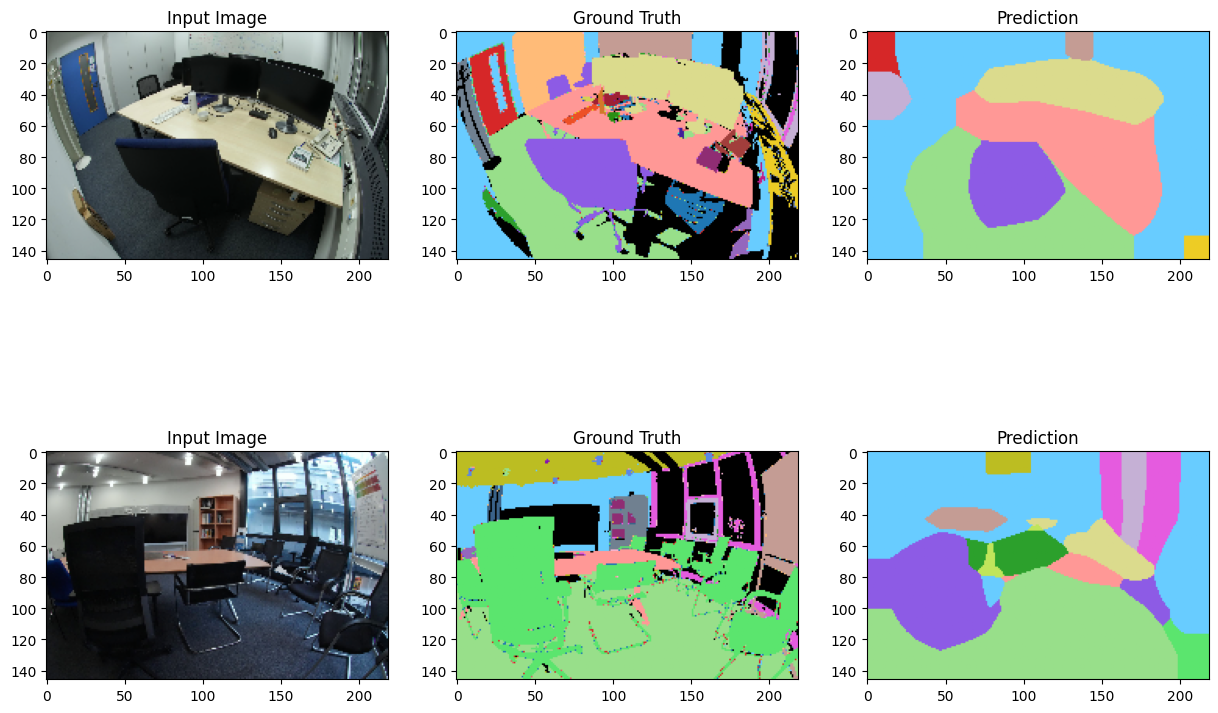

In [ ]:
# Inference and visualize predictions
inference_checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint_epoch_145.pth.tar')
inputs, labels, predictions = inference(model, val_loader, device, num_samples=2)
visualize_predictions(inputs, labels, predictions, palette_file='scripts/utils/palette_scannet200.txt')